Eager execution: True

Training on CIFAR-10 dataset...


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
391/391 - 28s - 72ms/step - accuracy: 0.4141 - loss: 1.6759 - val_accuracy: 0.4260 - val_loss: 1.6643
Epoch 2/20
391/391 - 25s - 65ms/step - accuracy: 0.5590 - loss: 1.2409 - val_accuracy: 0.5607 - val_loss: 1.2530
Epoch 3/20
391/391 - 26s - 65ms/step - accuracy: 0.6376 - loss: 1.0375 - val_accuracy: 0.5991 - val_loss: 1.1865
Epoch 4/20
391/391 - 25s - 65ms/step - accuracy: 0.6798 - loss: 0.9205 - val_accuracy: 0.7077 - val_loss: 0.8501
Epoch 5/20
391/391 - 26s - 66ms/step - accuracy: 0.7125 - loss: 0.8285 - val_accuracy: 0.6001 - val_loss: 1.2439
Epoch 6/20
391/391 - 26s - 65ms/step - accuracy: 0.7360 - loss: 0.7583 - val_accuracy: 0.6995 - val_loss: 0.8653
Epoch 7/20
391/391 - 26s - 65ms/step - accuracy: 0.7646 - loss: 0.6794 - val_accuracy: 0.6528 - val_loss: 1.0942
Epoch 8/20
391/391 - 25s - 65ms/step - accuracy: 0.7873 - loss: 0.6191 - val_accuracy: 0.7141 - val_loss: 0.8405
Epoch 9/20
391/391 - 25s - 65ms/step - accuracy: 0.8068 - loss: 0.5632 - val_accuracy: 0.7297 - 

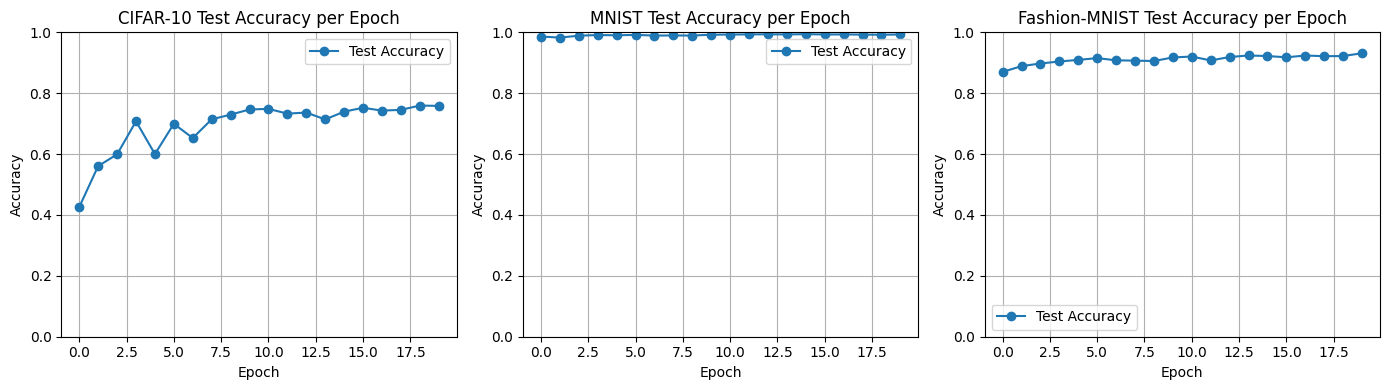


Final Test Accuracies:
CIFAR-10: 75.84%
MNIST: 99.29%
Fashion-MNIST: 93.14%


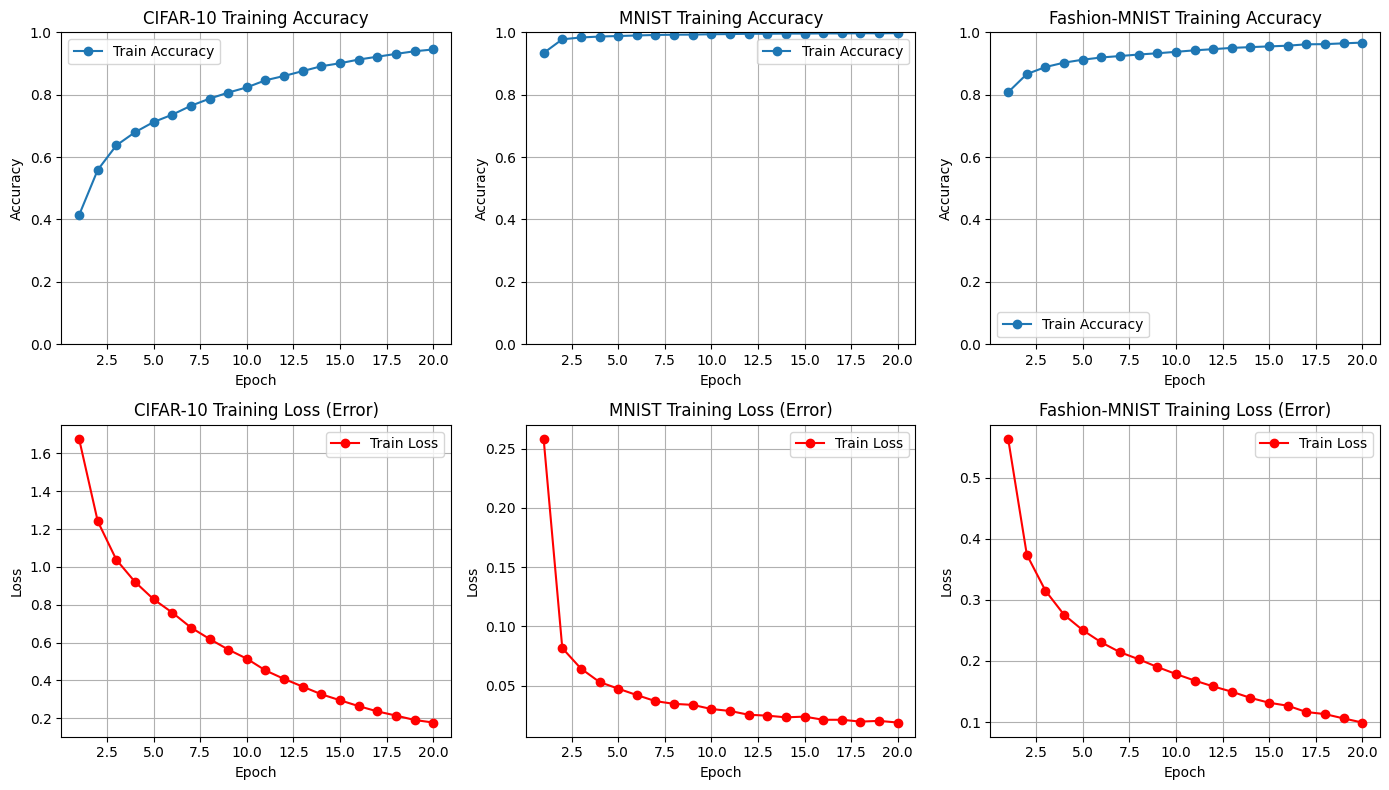

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist, fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

tf.config.run_functions_eagerly(True)
print("Eager execution:", tf.executing_eagerly())

# -----------------------------
# 1. Load and Preprocess Data
# -----------------------------
def preprocess_data(x_train, y_train, x_test, y_test, num_classes, resize_to=None):
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0

    if len(x_train.shape) == 3:
        x_train = np.expand_dims(x_train, -1)
        x_test  = np.expand_dims(x_test, -1)
    
    if resize_to is not None:
        x_train = tf.image.resize(x_train, [resize_to, resize_to]).numpy()
        x_test  = tf.image.resize(x_test, [resize_to, resize_to]).numpy()
    
    y_train = to_categorical(y_train, num_classes)
    y_test  = to_categorical(y_test, num_classes)
    
    return x_train, y_train, x_test, y_test

# Load CIFAR-10 (already 32x32 and RGB)
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
cifar10_x_train, cifar10_y_train, cifar10_x_test, cifar10_y_test = preprocess_data(
    cifar10_x_train, cifar10_y_train, cifar10_x_test, cifar10_y_test, num_classes=10)

# Load MNIST (28x28 grayscale, so we resize to 32x32)
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test = preprocess_data(
    mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test, num_classes=10, resize_to=32)

# Load Fashion-MNIST (28x28 grayscale, so we resize to 32x32)
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()
fashion_x_train, fashion_y_train, fashion_x_test, fashion_y_test = preprocess_data(
    fashion_x_train, fashion_y_train, fashion_x_test, fashion_y_test, num_classes=10, resize_to=32)

# ----------------------------------------
# 2. Build the SCNNB (Shallow CNN with BN)
# ----------------------------------------
def build_scnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape,
                     kernel_regularizer=tf.keras.regularizers.l2(0.000005)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.000005)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(1280, kernel_regularizer=tf.keras.regularizers.l2(0.000005)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# ------------------------
# 3. Training and Evaluation
# ------------------------
batch_size = 128
epochs = 20
learning_rate = 0.02
momentum = 0.9

datasets = {
    "CIFAR-10": (cifar10_x_train, cifar10_y_train, cifar10_x_test, cifar10_y_test),
    "MNIST": (mnist_x_train, mnist_y_train, mnist_x_test, mnist_y_test),
    "Fashion-MNIST": (fashion_x_train, fashion_y_train, fashion_x_test, fashion_y_test)
}

histories = {}
test_accuracies = {}

for name, (x_train, y_train, x_test, y_test) in datasets.items():
    print(f"\nTraining on {name} dataset...")
    model = build_scnn_model(input_shape=x_train.shape[1:], num_classes=10)
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                        validation_data=(x_test, y_test), verbose=2)
    
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Accuracy for {name}: {test_acc*100:.2f}%")
    
    histories[name] = history.history
    test_accuracies[name] = test_acc

# --------------------------
# 4. Plotting the results
# --------------------------
plt.figure(figsize=(14, 4))
for idx, name in enumerate(datasets.keys()):
    plt.subplot(1, 3, idx+1)
    plt.plot(histories[name]['val_accuracy'], marker='o', label='Test Accuracy')
    plt.title(f"{name} Test Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

print("\nFinal Test Accuracies:")
for name, acc in test_accuracies.items():
    print(f"{name}: {acc*100:.2f}%")

plt.figure(figsize=(14, 8))
for idx, name in enumerate(datasets.keys()):
    history = histories[name]
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    plt.subplot(2, 3, idx+1)
    plt.plot(epochs_range, history['accuracy'], marker='o', label='Train Accuracy')
    plt.title(f"{name} Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1])
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 3, idx+4)
    plt.plot(epochs_range, history['loss'], marker='o', color='red', label='Train Loss')
    plt.title(f"{name} Training Loss (Error)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

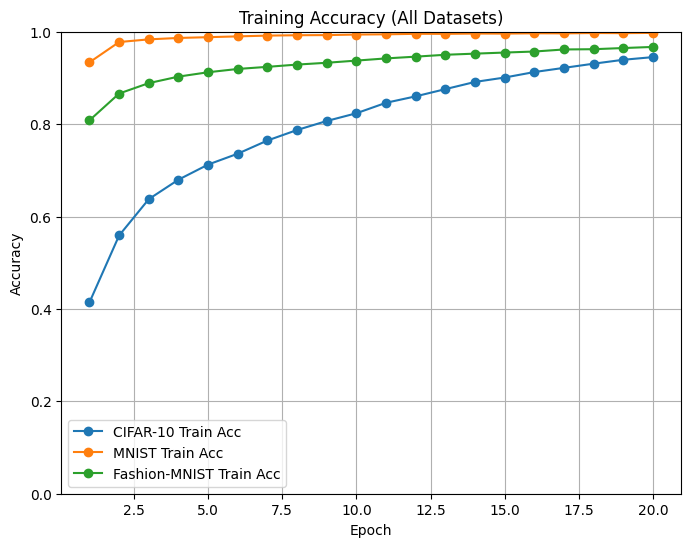

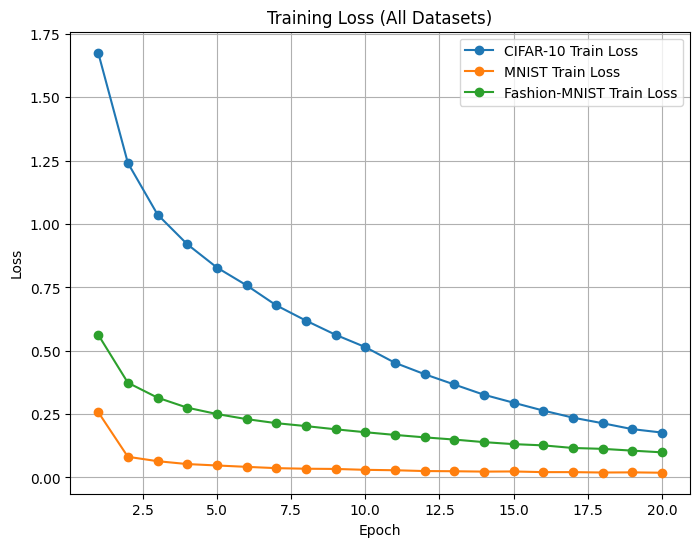

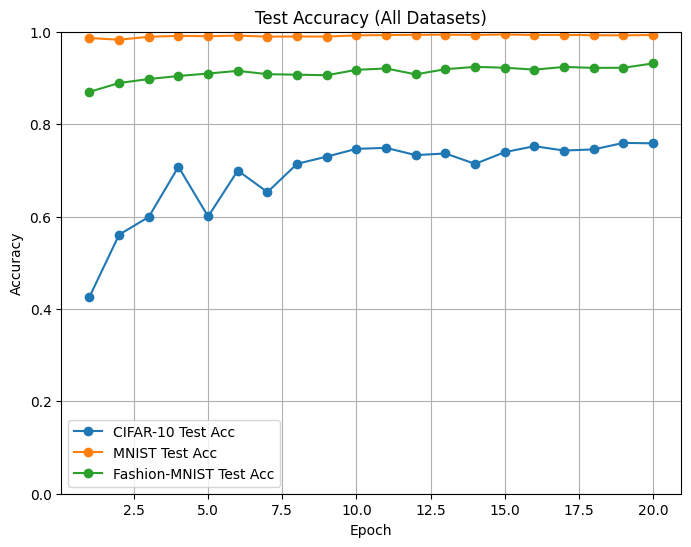

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for name, history in histories.items():
    epochs_range = range(1, len(history['accuracy']) + 1)
    plt.plot(epochs_range, history['accuracy'], marker='o', label=f"{name} Train Acc")
plt.title("Training Accuracy (All Datasets)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for name, history in histories.items():
    epochs_range = range(1, len(history['loss']) + 1)
    plt.plot(epochs_range, history['loss'], marker='o', label=f"{name} Train Loss")
plt.title("Training Loss (All Datasets)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
for name, history in histories.items():
    epochs_range = range(1, len(history['val_accuracy']) + 1)
    plt.plot(epochs_range, history['val_accuracy'], marker='o', label=f"{name} Test Acc")
plt.title("Test Accuracy (All Datasets)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend()
plt.grid(True)
plt.show()